In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import numpy as np
import pandas as pd

from support.charting import primaryColors, fullColors, save_fig
from support.load     import loadAllData, methodParams
from support.util     import titles, order

from IPython.core import display as ICD

/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
data = loadAllData()
sns.set_style('white')

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScen

In [3]:
convergences = {
    'dps':{},
    'plannedadaptive':{},
    'intertemporal':{}
}

for method, methodData in data.items(): 
    for model, convergence in methodData['convergences'].items(): 
        convergences[model][method] = convergence

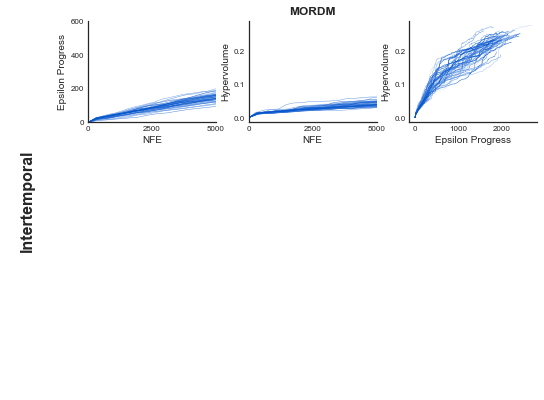

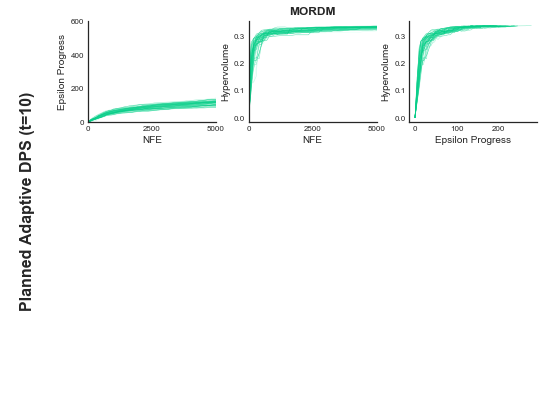

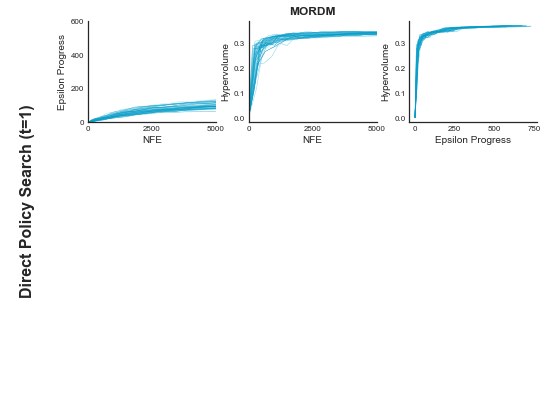

In [14]:
xs = ['nfe','nfe','epsilon_progress']
ys = ['epsilon_progress','hypervolume','hypervolume']

xax = ['NFE','NFE','Epsilon Progress']
yax = ['Epsilon Progress','Hypervolume','Hypervolume']

for modelIdx, model in enumerate(order('model')):

    f = plt.figure(figsize=(7.5, 5.5))

    gs0 = gridspec.GridSpec(3, 2, width_ratios=[0.25, 20])

    header = plt.Subplot(f, gs0[0:3, 0])
    f.add_subplot(header)
    header.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    header._frameon = False
    header.text(0.5,0.5, titles('model')[modelIdx].replace('\n',' '), 
                ha='center', va='center',weight='bold', fontsize=16, rotation='vertical')

    for methodIdx, method in enumerate(order('method')): 
        gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[methodIdx*2+1])
        for plotIdx in range(len(xs)): 
            ax = plt.Subplot(f, gs00[0, plotIdx])
            f.add_subplot(ax)

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_xlabel(xax[plotIdx])
            ax.set_ylabel(yax[plotIdx])

            if plotIdx == 1: 
                ax.set_title(titles('method')[methodIdx], fontsize=12, weight='bold')

            convs = convergences[model][method]
            runs = len(convs[0]['run_index'].unique())
            if len(convs) == 1:
                palettes = [sns.light_palette(primaryColors[model][method],n_colors=runs)]
            else:
                palettes = [[elem] * runs for elem in fullColors[model][method]]

            grouped = []
            for idx, elem in enumerate(convs):
                grouped.append(elem.groupby(['run_index']))

            for groupIdx, conv in enumerate(grouped): 
                for name, group in conv:
                    ax.plot(group[xs[plotIdx]],group[ys[plotIdx]],color=palettes[groupIdx][name], linewidth=0.5)

            nfe = methodParams[method].nfeOptimize[model]
            if plotIdx < 2: 
                ax.set_xticks([0,nfe/2,nfe])

            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(8)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(8) 
    plt.tight_layout(pad=0.5, w_pad=2.5)
    save_fig(f, 'images/convergences/', 'convergence_' + model)
    plt.show()

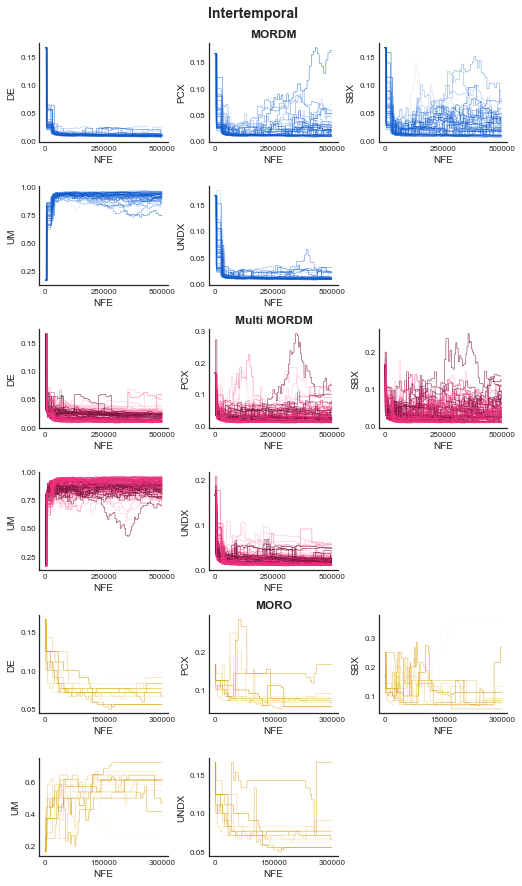

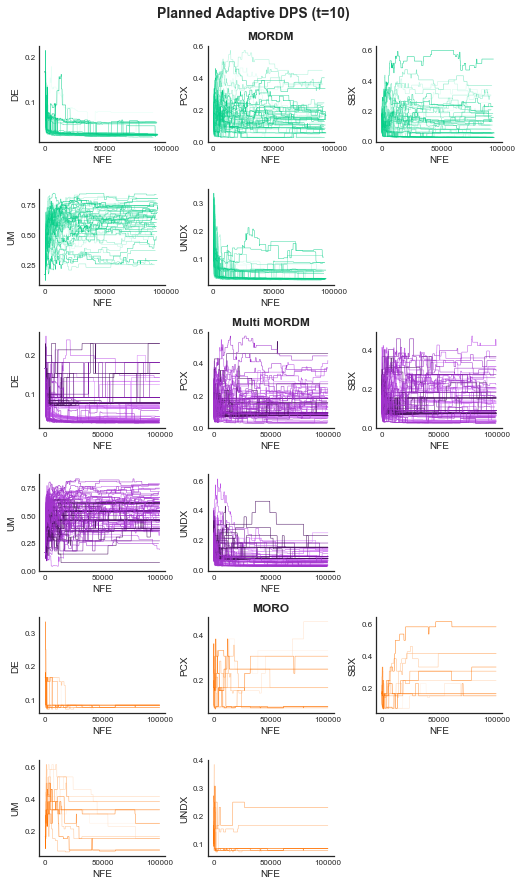

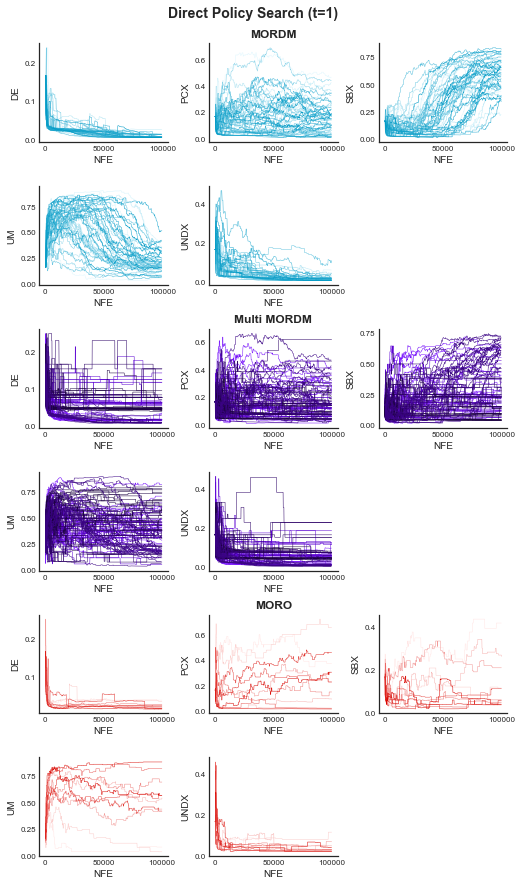

In [7]:
xs = ['nfe','nfe','nfe','nfe','nfe',None]
ys = ['DE','PCX','SBX','UM','UNDX',None]

xax = ['NFE','NFE','NFE','NFE','NFE',None]
yax = ['DE','PCX','SBX','UM','UNDX',None]

for modelIdx, model in enumerate(order('model')):
    fig, big_axes = plt.subplots(figsize=(7.5, 12), nrows=6, ncols=1, sharey=True) 

    for row, big_ax in enumerate(big_axes):
        if row % 2 == 0: 
            big_ax.set_title(titles('method')[int(row/2)], fontsize=12, weight='bold')
        big_ax.tick_params(labelcolor=(1.0, 1.0, 1.0, 0.0), top='off', bottom='off', left='off', right='off')
        big_ax._frameon = False
        
    i = 1
    for methodIdx, method in enumerate(order('method')): 
        for plotIdx in range(len(xs)): 
            ax = fig.add_subplot(6,3,i)
            i += 1
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_xlabel(xax[plotIdx])
            ax.set_ylabel(yax[plotIdx])
            
            if xs[plotIdx] is None:
                ax.set_visible(False)
                continue
            
            convs = convergences[model][method]
            runs = len(convs[0]['run_index'].unique())
            if len(convs) == 1:
                palettes = [sns.light_palette(primaryColors[model][method],n_colors=runs)]
            else:
                palettes = [[elem] * runs for elem in fullColors[model][method]]
            
            grouped = []
            for idx, elem in enumerate(convs):
                grouped.append(elem.groupby(['run_index']))
                
            for groupIdx, conv in enumerate(grouped): 
                for name, group in conv:
                    ax.plot(group[xs[plotIdx]],group[ys[plotIdx]],color=palettes[groupIdx][name], linewidth=0.5)
            
            nfe = methodParams[method].nfeOptimize[model]
            if plotIdx < 2: 
                ax.set_xticks([0,nfe/2,nfe])
            
            ax.set_xticks([0,nfe/2,nfe])
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(8)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(8)
    
    plt.suptitle(titles('model')[modelIdx].replace('\n',' '), fontsize=14, weight='bold', y=1.025)
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=-0.5)

    save_fig(fig, 'images/convergences/', 'operators_' + model)
    
    plt.show()

### MEANS

In [4]:
means = {
    'dps':{},
    'plannedadaptive':{},
    'intertemporal':{}
}

In [25]:
step = 100

for model, modelData in convergences.items(): 
    for method, convergence in modelData.items(): 
        print(model, method)
        means[model][method] = []      
        for conv in convergence: 
            runs = len(conv['run_index'].unique())
            currStep = 0
            meanlist_hyp = []
            meanlist_eps = []
            steplist = []
            while currStep <= methodParams[method].nfeOptimize[model]: 
                hypsum = 0
                epssum = 0
                for runIdx, group in conv.groupby('run_index'):
                    exact = group[group['nfe'].eq(currStep)]
                    if len(exact) > 0: 
                        hypsum += exact.iloc[0]['hypervolume']
                        epssum += exact.iloc[0]['epsilon_progress']
                    else: 
                        gt = group[group['nfe'].gt(currStep)]
                        if len(gt) == 0: # there is no element greater than the current nfe. Therefore, you have reached the end. 
                            gt = group.shape[0]-1
                            hypsum += group.iloc[gt]['hypervolume']
                            epssum += group.iloc[gt]['epsilon_progress']
                        else: 
                            gt = gt.index[0]
                        
                            dx = group.iloc[gt]['nfe'] - group.iloc[gt-1]['nfe']
                            dy1 = group.iloc[gt]['hypervolume'] - group.iloc[gt-1]['hypervolume']
                            dy2 = group.iloc[gt]['epsilon_progress'] - group.iloc[gt-1]['epsilon_progress']

                            dx_diff = group.iloc[gt]['nfe'] - currStep

                            hypsum += group.iloc[gt]['hypervolume'] - dy1/dx*dx_diff
                            epssum += group.iloc[gt]['epsilon_progress'] - dy2/dx*dx_diff
                
                meanlist_hyp.append(hypsum/runs)
                meanlist_eps.append(epssum/runs)
                steplist.append(currStep)
                currStep += step
            
            means[model][method].append({'hypervolume':meanlist_hyp, 'epsilon_progress':meanlist_eps, 'step':steplist})

pickle.dump( means, open( "means.p", "wb" ) )

dps mordm
dps multi
dps moro
plannedadaptive mordm
plannedadaptive multi
plannedadaptive moro
intertemporal mordm
intertemporal multi
intertemporal moro


In [5]:
means = pickle.load( open( "means.p", "rb" ) )

In [6]:
norm = means.copy()
for model in order('model'): 
    for method in order('method'): 
        for lst in means[model][method]: 
            lst['epsilon_progress'] = [float(i)/max(lst['epsilon_progress']) for i in lst['epsilon_progress']]
            lst['hypervolume'] = [float(i)/max(lst['hypervolume']) for i in lst['hypervolume']]

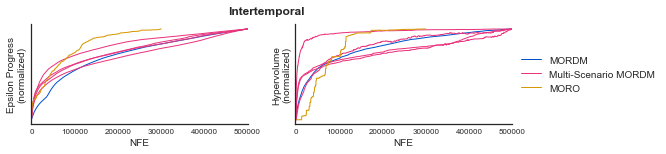

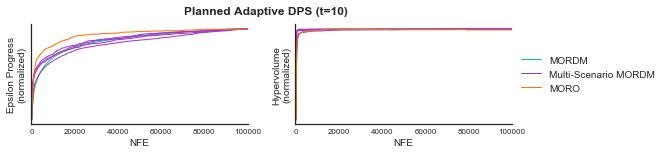

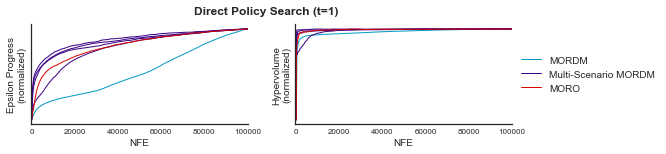

In [8]:
xs = ['step','step']
ys = ['epsilon_progress','hypervolume']

xax = ['NFE','NFE']
yax = ['Epsilon Progress\n(normalized)','Hypervolume\n(normalized)']

for modelIdx, model in enumerate(order('model')):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 2), sharex=False, sharey=False)
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_xlabel(xax[plotIdx])
        ax.set_ylabel(yax[plotIdx])
    
    for methodIdx, method in enumerate(order('method')): 
        for plotIdx in range(0,2):    
            ax = axes[plotIdx]
            
            convs = norm[model][method]
            for groupIdx, conv in enumerate(convs): 
                if (groupIdx == 0):
                    ax.plot(conv[xs[plotIdx]],conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1, label=titles('method')[methodIdx])
                else: 
                    if (groupIdx < len(convs)-1):
                        ax.plot(conv[xs[plotIdx]],conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1)
            
            nfe = methodParams[method].nfeOptimize[model]
            if plotIdx < 2: 
                ax.set_xticks([0,nfe/2,nfe])
                ax.set_yticks([])
    
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]            
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        
        if model=='intertemporal':
            ax.set_xlim(-2000,500000)
            ax.set_xticks(np.arange(0, 500001, step=100000))
        else: 
            ax.set_xlim(-500,100000)
            ax.set_xticks(np.arange(0, 100001, step=20000))
        
    plt.suptitle(titles('model')[modelIdx].replace('\n',' '), fontsize=12, weight='bold', y=1.05)
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    save_fig(fig, 'images/convergences/', 'meanconvergence_normalized_' + model)
    plt.show()

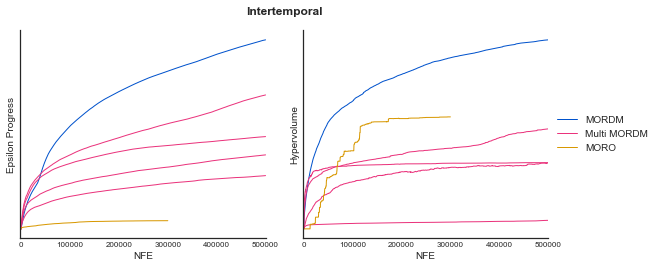

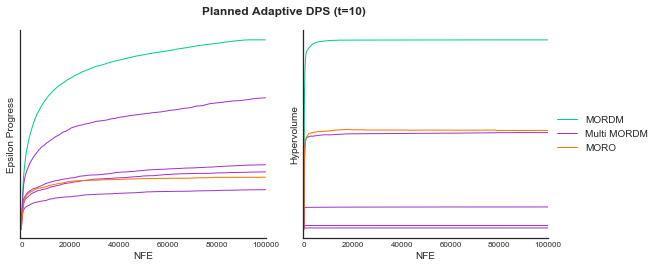

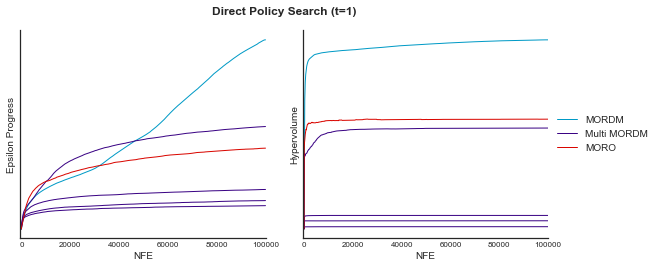

In [37]:
xs = ['step','step']
ys = ['epsilon_progress','hypervolume']

xax = ['NFE','NFE']
yax = ['Epsilon Progress','Hypervolume']

for modelIdx, model in enumerate(order('model')):     
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharex=False, sharey=False)
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_xlabel(xax[plotIdx])
        ax.set_ylabel(yax[plotIdx])
    
    for methodIdx, method in enumerate(order('method')): 
        for plotIdx in range(0,2):    
            ax = axes[plotIdx]
            
            convs = means[model][method]
            for groupIdx, conv in enumerate(convs): 
                if (groupIdx == 0):
                    ax.plot(conv[xs[plotIdx]],conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1, label=titles('method')[methodIdx])
                else: 
                    if (groupIdx < len(convs)-1 ):
                        ax.plot(conv[xs[plotIdx]],conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1)
                        
            nfe = methodParams[method].nfeOptimize[model]
            if plotIdx < 2: 
                ax.set_xticks([0,nfe/2,nfe])
                ax.set_yticks([])
                
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]            
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        
        if model=='intertemporal':
            ax.set_xlim(-2000,500000)
            ax.set_xticks(np.arange(0, 500001, step=100000))
        else: 
            ax.set_xlim(-500,100000)
            ax.set_xticks(np.arange(0, 100001, step=20000))
        
    plt.suptitle(titles('model')[modelIdx].replace('\n',' '), fontsize=12, weight='bold', y=1.05)
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    
    save_fig(fig, 'images/convergences/', 'meanconvergence_' + model)
    
    plt.show()
        

# SLOPE

In [40]:
def slopefunc(x, y): 
    slope = []
        
    prevA = None
    prevB = None
    for a,b in zip(x,y): 
        if not prevA == None: 
            dy = (b-prevB)
            dx = (a-prevA) * 1.0
            slope.append(dy/dx)
            
        prevA = a
        prevB = b
        
    return slope

In [42]:
slopes = {
    'dps':{},
    'plannedadaptive':{},
    'intertemporal':{}
}

for model, modelData in means.items(): 
    for method, convergence in modelData.items():
        print(model, method)
        slopes[model][method] = []
        for convIdx, conv in enumerate(convergence): 
            slopelist = {}
            for slopetype in ['hypervolume','epsilon_progress']: 
                slopelist[slopetype] = slopefunc(conv['step'],conv[slopetype])
            slopes[model][method].append(slopelist)

dps mordm
dps multi
dps moro
plannedadaptive mordm
plannedadaptive multi
plannedadaptive moro
intertemporal mordm
intertemporal multi
intertemporal moro


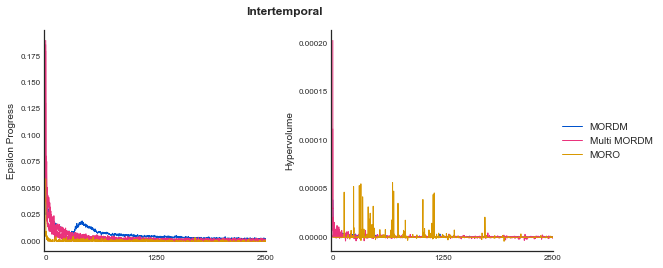

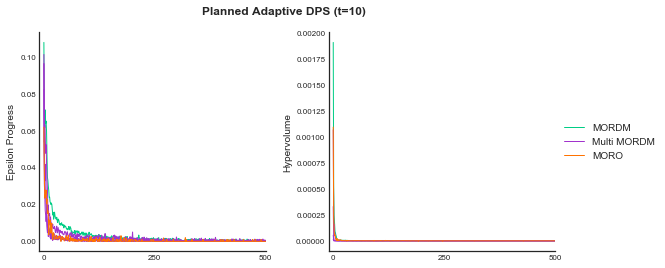

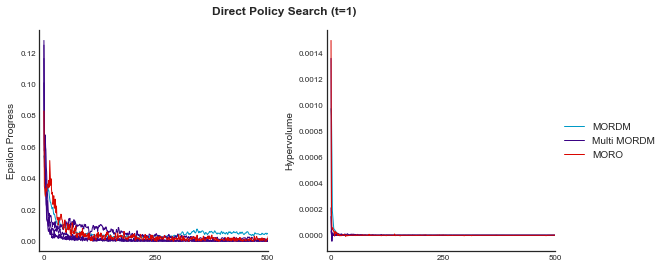

In [43]:
xs = ['step','step']
ys = ['epsilon_progress','hypervolume']

xax = ['NFE','NFE']
yax = ['Epsilon Progress','Hypervolume']

for modelIdx, model in enumerate(order('model')):     
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharex=False, sharey=False)
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

#         ax.set_xlabel(xax[plotIdx])
        ax.set_ylabel(yax[plotIdx])
    
    for methodIdx, method in enumerate(order('method')): 
        for plotIdx in range(0,2):    
            ax = axes[plotIdx]
            
            convs = slopes[model][method]
            for groupIdx, conv in enumerate(convs): 
                if (groupIdx == 0):
                    ax.plot(conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1, label=titles('method')[methodIdx])
                else: 
                    if (groupIdx < len(convs)-1 ):
                        ax.plot(conv[ys[plotIdx]],color=primaryColors[model][method], linewidth=1)
            
#             nfe = params[method].nfeOptimize[model]
#             if plotIdx < 2: 
#                 ax.set_xticks([0,nfe/2,nfe])
    
    for plotIdx in range(0,2): 
        ax = axes[plotIdx]            
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        
        if model=='intertemporal':
            ax.set_xlim(-20,2500)
            ax.set_xticks(np.arange(0, 2501, step=1250))
            
#             ax.set_ylim(0,0.075)
        else: 
            ax.set_xlim(-10,500)
            ax.set_xticks(np.arange(0, 501, step=250))
            
#             ax.set_ylim(0,0.04)
        
    plt.suptitle(titles('model')[modelIdx].replace('\n',' '), fontsize=12, weight='bold', y=1.05)
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()
        

In [46]:
slopes = {
    'dps':{},
    'plannedadaptive':{},
    'intertemporal':{}
}

for model, modelData in convergences.items(): 
    for method, convergence in modelData.items():
        print(model, method)
        slopes[model][method] = {}
        for tp in ['hypervolume','epsilon_progress']:
            slopes[model][method][tp] = []
            for convIdx, conv in enumerate(convergence): 
                slopelist = []
                for idx, group in conv.groupby('run_index'): 
                    slopelist.append(slopefunc(group['nfe'],group[tp]))
                slopes[model][method][tp].append(slopelist)   

dps mordm
dps multi
dps moro
plannedadaptive mordm
plannedadaptive multi
plannedadaptive moro
intertemporal mordm
intertemporal multi
intertemporal moro


intertemporal


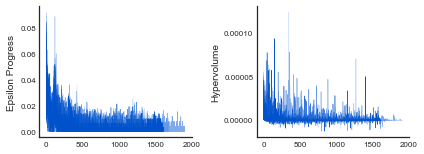

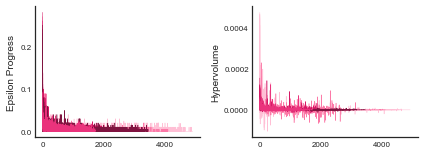

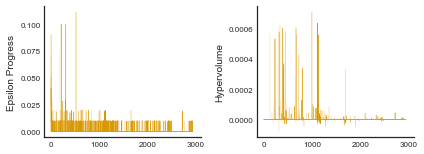

plannedadaptive


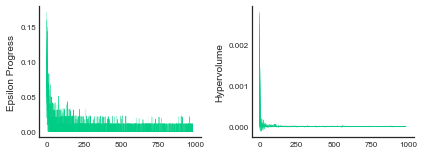

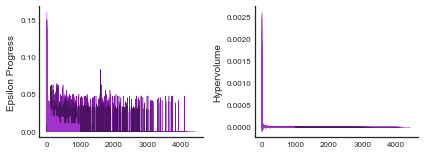

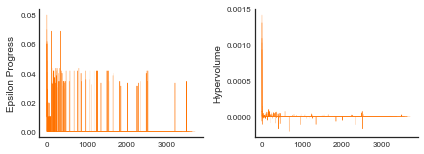

dps


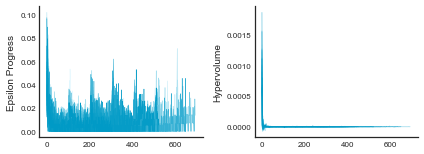

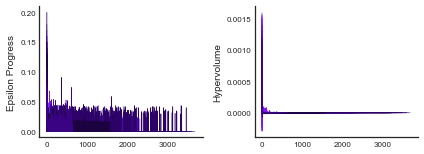

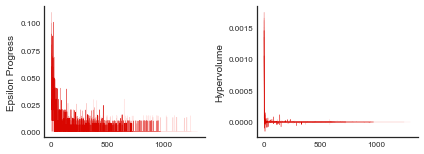

In [50]:
ys = ['epsilon_progress','hypervolume']

yax = ['Epsilon Progress','Hypervolume']

for modelIdx, model in enumerate(order('model')):
    print(model)
    for methodIdx, method in enumerate(order('method')): 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.25), sharex=False, sharey=False)

        for plotIdx in range(0,2): 
            ax = axes[plotIdx]
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            
            ax.set_ylabel(yax[plotIdx])
            
            slopeData = slopes[model][method][ys[plotIdx]]
            runs = len(slopeData[0])
            if len(slopeData) == 1:
                palettes = [sns.light_palette(primaryColors[model][method],n_colors=runs)]
            else:
                palettes = [[elem] * runs for elem in fullColors[model][method]]
            
            for groupIdx, slope in enumerate(slopeData): 
                for runIdx, plotData in enumerate(slope): 
                    ax.plot(plotData,color=palettes[groupIdx][runIdx], linewidth=0.5)
                            
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(8)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(8)   
#         plt.suptitle(titles('method')[methodIdx].replace('\n',' '), fontsize=12, weight='bold', y=1.02)
        plt.tight_layout()
        plt.show()